<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Prepare-data" data-toc-modified-id="Prepare-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Prepare data</a></span></li><li><span><a href="#Compare-methods" data-toc-modified-id="Compare-methods-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Compare methods</a></span></li><li><span><a href="#Analyze-clustering" data-toc-modified-id="Analyze-clustering-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Analyze clustering</a></span></li><li><span><a href="#Is-our-clustering-stable-across-waves?" data-toc-modified-id="Is-our-clustering-stable-across-waves?-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Is our clustering stable across waves?</a></span></li><li><span><a href="#Soft-Clustering-(Fuzzy-K-means)" data-toc-modified-id="Soft-Clustering-(Fuzzy-K-means)-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Soft Clustering (Fuzzy K-means)</a></span></li><li><span><a href="#consistency-regarding-only-continuous-(repeated-in-different-waves)-questions" data-toc-modified-id="consistency-regarding-only-continuous-(repeated-in-different-waves)-questions-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>consistency regarding only continuous (repeated in different waves) questions</a></span><ul class="toc-item"><li><span><a href="#Deviations-for-the-same-opinion-questions-across-the-waves" data-toc-modified-id="Deviations-for-the-same-opinion-questions-across-the-waves-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Deviations for the same opinion questions across the waves</a></span></li><li><span><a href="#Checking-consistency-of-confidently-clustered-samples-among-the-same-questions-in-different-waves" data-toc-modified-id="Checking-consistency-of-confidently-clustered-samples-among-the-same-questions-in-different-waves-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Checking consistency of confidently clustered samples among the same questions in different waves</a></span></li></ul></li></ul></div>

# Clustering

Initially we looked at correlation between features and noticed that the largest ones (in terms of magnitude) appeared amongst the **opinion** question. So the question arose
> Can we group participants into two classes based on their political opinion?


In [1]:
import sys
sys.path.insert(0, '../helpers')

from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA, KernelPCA
from sklearn import cluster, metrics, mixture
from scipy.spatial.distance import cdist
from PIL import Image
import ipywidgets as widgets
from ipywidgets import interact, interact_manual  # , interactive
from IPython.display import display, clear_output
from dictionaries_rename import *
from Helper_functions import *
import pylab
from itertools import repeat
import csv
import warnings
from collections import Counter
import skfuzzy as fuzz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

warnings.filterwarnings('ignore')

pd.set_option('display.max_colwidth', None)
pd.set_option("display.precision", 2)
%matplotlib inline

[NbConvertApp] WARNING | pattern 'dictionaries_rename.ipynb' matched no files


This application is used to convert notebook files (*.ipynb) to various other
formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Execute the notebook prior to export.
    Equivalent to: [--ExecutePreprocessor.enabled=True]
--allow-errors
    Continue notebook execution even if one of the cells throws an error and include the error message in the cell output (the default behaviour is to abort conversion). This flag is only relevant if '--execute' was specified, too

usage: jupyter-nbconvert [-h] [--debug] [--generate-config] [-y] [--execute]
                         [--allow-errors] [--stdin] [--stdout] [--inplace]
                         [--clear-output] [--no-prompt] [--no-input]
                         [--allow-chromium-download]
                         [--log-level NbConvertApp.log_level]
                         [--config NbConvertApp.config_file]
                         [--to NbConvertApp.export_format]
                         [--template TemplateExporter.template_name]
                         [--template-file TemplateExporter.template_file]
                         [--writer NbConvertApp.writer_class]
                         [--post NbConvertApp.postprocessor_class]
                         [--output NbConvertApp.output_base]
                         [--output-dir FilesWriter.build_directory]
                         [--reveal-prefix SlidesExporter.reveal_url_prefix]
                         [--nbformat NotebookExporter.nbformat_vers

## Prepare data

In [2]:
%run Prepare_clustering_data.ipynb

The number of people who answered one of the check questions incorrectly is 1207.


In [3]:
# filtering questions not containing only immigration related tag, excluding wave 6 as there are no immigration questions (like 1 or 2 samples)
waves = ['1', '2', '3', '4', '5', '6']
for wave in waves:
    df_opinion[wave] = df_opinion[wave].drop(df_opinion[wave].filter(like='im', axis=1).columns, axis=1)

## Compare methods

In this section we investigated different clustering methods performance (with Kmeans being the most efficient one) and tried to obtain the most optimal number of clusters (which eventually is 2). For more details, see [Compare_clustering_methods notebook](./Compare_clustering_methods.ipynb)

## Analyze clustering

We use the Kmeans algorithm since it performed the best in the previous evaluations. This method not only compute a clustering but also a *centroid* for every cluster and the distance of every point to those centers. Every point will simply be assigned to the centroid to which it has this smallest distance. If the distance of a point to its centroid is much smaller than its distance to the other centroid we tend to be more confident in it's assignment. So we compute quotient of the distances to the two centroids. Next we compute the median of all quotients of all points in a class and call the closest half *close* and the half that is further away than this median *far*.

In [4]:
def add_closeness_label(df, n):
    """Given a clustering in a dataframe decide for every point whether it is 
    close of far from its centroid. This should reflect the confidence with 
    which the point is assinged to its cluster."""

    df['Distance'] = np.NaN
    for lab in range(n):
        df_lab = df.loc[df.Label == lab]
        threshold = df_lab['quotient'].quantile(.8)

        # ideally if the quotient is NaN (i.e. person didn't participate in this wave)
        # the label should be NaN, but for this to work we still have to change the
        # later code.
        df.loc[df.Label == lab, 'Distance'] = df_lab['quotient'].apply(
            lambda x: 'Far from centroid' if x > threshold else 'Close to centroid')

    return df


def compute_clusters(X, n):
    """Clusters dataset into n groups and additionally asigns every point a label 
    depending on whether it is 'close' and 'far' from centroid,
    hoping that close ones are clustered more confidently

    :return:
    - df_clusters: a dataframe with colums consisting of index being the index of X (id of the
                participant) and columns `Label` for the assined cluster as well as `quotient` 
                which is the ratio of distance to the closest and the fartest centroid.
    - centroids: a list of the coordinates of the `n` centroids.

    """

    kmeans = cluster.KMeans(n_clusters=n, random_state=42).fit(X)
    X_dist = kmeans.transform(X)
    quotient = X_dist.min(axis=1)/X_dist.max(axis=1)
    df_cluster = pd.DataFrame(quotient, columns=['quotient'])
    df_cluster.index = X.index
    df_cluster['Label'] = kmeans.labels_
    centroids = kmeans.cluster_centers_

    df = add_closeness_label(df_cluster, n)

    return df, centroids

For illustration purposes we also compute a principal component analysis (PCA) of all the opinion question which allows us to visualize the obtained clustering and centroids in a lower dimensional space.

In [5]:
def compute_PCA(df, centroids):
    """Compute PCA of opinion questions and transform data and centroids into new 
    coordinate system."""

    # 2 components for 2D visualization
    pca = PCA(n_components=2)
    pca.fit(df)

    # show how much information our components contain
    explained_variance = pd.DataFrame(pca.explained_variance_ratio_).T

    # obtain data transformed into 2 dimensions for illustration purposes
    df_pc = pd.DataFrame(pca.transform(df))
    df_pc.columns = ['1st component', '2nd component']
    df_pc.index = df.index

    # centroid coordinates for illustration / filtering confidently assigned samples
    centroids_pc = pca.transform(centroids)

    return df_pc, centroids_pc, explained_variance, pca.components_

Additionally, for every question we compute the average strength of agreement for people of the same cluster and compare these values between the groups. We only list here the subset of question with the largest difference in agreement between the two groups.

In [6]:
def sort_by_absolute_val(df, column):
    """Sort df column by descending order in terms of the absolute value."""
    df = df.reindex(df[column]
                    .abs()
                    .sort_values(ascending=False)
                    .index)
    return df

In [7]:
def waves_to_switch(df, wave):
    """in order to compare cluster assignment stability we would
    like to be sure that labels assigned have the same magnitude
    (otherwise the same cluster might have label 1 for one wave and
    label 0 for another one"""

    if wave == str(5):
        if df.loc['PEOPLE LIKE ME GET LESS ATTENTION THAN OTHERS ', 'Difference'] > 0:
            print(f'Switch label signs for wave: {wave}')
            return wave
    else:
        if df.loc['POLITICIANS DO NOT CARE ABOUT WHAT PEOPLE LIKE ME THINK ', 'Difference'] > 0:
            print(f'Switch label signs for wave: {wave}')
            return wave

In [8]:
def compute_cluster_differences(df, wave):
    """Computes for both classes the average agreement for the different questions"""

    df_cluster_means = df.groupby(['Label']).mean().T
    differences = (
        df_cluster_means[0]-df_cluster_means[1]).sort_values(ascending=False)
    strongest_differences = pd.DataFrame(differences)
    strongest_differences.columns = ['Difference']

    strongest_differences = strongest_differences[~strongest_differences.index.duplicated(
    )]

    strongest_differences = sort_by_absolute_val(
        strongest_differences, 'Difference')
    wave_to_switch = waves_to_switch(strongest_differences, wave)

    return strongest_differences, wave_to_switch

In [9]:
def find_max_differences(df, wave):
    """Computes mean opinions among classes,
    as well as standart deviation, prints 10 questions with the largest distance
    from mean among classes in descending order

    :input: 
    - df with opinions for each sample and every question merged with cluster labels. 
    - wave.

    :return:
    - df with the questions (as indexes), which contribute to the largest difference 
            between mean value of cluster $j$ and mean of means of other clusters. 
            Questions are sorted in descending order. Mean value of cluster $j$, then its difference 
            from other 3 clusters and std are provided in columns.

    """

    # compute mean and std for every cluster
    opinion_stats = df.groupby(['Label']).mean().T
    opinion_std = df.groupby(['Label']).std().T
    opinion_std.columns = [str(i) + '_std' for i in opinion_std.columns]
    labels_number = len(Counter(df.Label))

    # find the difference of mean inside cluster from the mean of the three out-of-class means
    for label in range(labels_number):
        opinion_stats['diff_mean' +
                      str(label)] = opinion_stats[label] - opinion_stats.drop(label, axis=1).mean(axis=1)

    opinion_stats = pd.concat([opinion_stats, opinion_std], axis=1)
    # sort the most important factors by abs value of difference (with sign remain unchanged eventually)
    opinion_stats_sorted_all = {}
    for label in range(labels_number):
        # opinion_stats_sorted = opinion_stats.sort_values(
        #    by='diff_mean'+str(label), ascending=False)

        # exclude label column to compute difference with other means
        for other_class_label in range(labels_number):
            opinion_stats[f'diff_means{other_class_label}'] = opinion_stats[other_class_label] - \
                opinion_stats[label]

        opinion_stats_sorted = sort_by_absolute_val(
            opinion_stats, f'diff_mean{label}')

        # renaming 0,1,2,3 to mean_0 etc
        opinion_stats_sorted.columns.values[[0, 1, 2, 3]] = [
            'mean_0', 'mean_1', 'mean_2', 'mean_3']

        # drop cols with differences of mean_j and mean_j (with 0 entries)
        opinion_stats_sorted = opinion_stats_sorted.loc[:, (opinion_stats_sorted != 0).any(
            axis=0)]

        mean_inside_cluster = opinion_stats_sorted.filter(
            like=f'mean_{label}', axis=1)
        differences_out = opinion_stats_sorted.filter(
            like='diff_means', axis=1)
        std_all = opinion_stats_sorted.filter(like='std', axis=1)
        info_to_display = pd.concat(
            [mean_inside_cluster, differences_out, std_all], axis=1)
        opinion_stats_sorted_all[label] = info_to_display[:5]
    return opinion_stats_sorted_all

In [10]:
def sort_eigenvec(eigen_vec, feature_names):
    """
    Finds features that explain the most variance.

    :input:
    eigenv_vec: An eigenvalue computed by PCA.
    feature_names: The list of opinion questions.

    :return:
    Create df which contains the single given eigenvalue. 
    Every component of which corresponds to a question. Additionally sort the 
    rows in such a way that the ones with larges absolute 
    value are on top.
    """

    df = pd.DataFrame(eigen_vec, index=feature_names,
                      columns=['Eigenvector coefficients'])
    df = sort_by_absolute_val(df, 'Eigenvector coefficients')

    return df

In [11]:
def plot_clustering(df_plot, centroids_transformed, wave):
    fig_dims = (12, 8)
    # no need to print it anymore due to space constraints, use widget in the next cell
    plt.ioff()
    fig, ax = plt.subplots(figsize=fig_dims)
    scatter = sns.scatterplot(data=df_plot,
                              x=df_plot['1st component'], y=df_plot['2nd component'],
                              hue="Label", style="Distance", s=80)
    centr = sns.scatterplot(centroids_transformed[:, 0], centroids_transformed[:, 1],
                            marker='+', color='black', s=300)
    n_clusters = df_plot['Label'].nunique()
    title = f'Kmeans scatter plot (with PCA), wave {wave}, {n_clusters} clusters'
    plt.title(title, size=15)
    # save png
    save_fig(title)
    plt.close()


def clustering_each_wave(wave, df, n):
    """Perform clustering of given wave and compute important quantities through PCA and other methods.

    :return:
    cluster_w:
    all_waves_clustering_info: Contains statistics about the computed clustering.
    wave_to_switch: gives insight whether we need to switch cluster labels to compare stability
    """

    # store the results in the nested dict
    all_waves_clustering_info = {}

    df_cluster, centroids = compute_clusters(df, n)

    clustering_info = {}
    # compute coordinates with respect to new basis
    df_pc, centroids_pc, explained_variance, eigenvectors = compute_PCA(
        df, centroids)
    clustering_info[f'Explained variance, wave {wave}'] = explained_variance

    # get most important features of principle components
    clustering_info[f'Important features (PCA), 1 component, w{wave}'] = sort_eigenvec(
        eigenvectors[0], df.columns)
    clustering_info[f'Important features (PCA), 2 component, w{wave}'] = sort_eigenvec(
        eigenvectors[1], df.columns)

    # plotting
    df_plot = pd.concat([df_pc, df_cluster.Label, df_cluster.Distance], axis=1)
    plot_clustering(df_plot, centroids_pc, wave)

    # add cluster label column
    df = pd.concat([df, df_cluster['Label']], axis=1)

    # different functions to obtain the most important factors for different numbers of clusters
    if n == 2:
        strongest_differences, wave_to_switch = compute_cluster_differences(
            df, wave)
        clustering_info[
            f'The most important factors regarding differences between clusters, w{wave}'] = strongest_differences
    else:
        opinion_stats_sorted_all = find_max_differences(df, wave)
        clustering_info[
            f'The most important factors regarding differences between clusters, w{wave}'] = opinion_stats_sorted_all
        wave_to_switch = []
    cluster_w = df_cluster.drop(columns='quotient')

    cluster_w = cluster_w.replace({'Distance':
                                   {"Close to centroid": 1,
                                    "Far from centroid": 0}})
    cluster_w = cluster_w.rename(
        {'Label': f'Label w{wave}', 'Distance': f'Close to centroid w{wave}'}, axis=1)

    all_waves_clustering_info[wave] = clustering_info
    return cluster_w, all_waves_clustering_info, wave_to_switch

Execute `clustering_each_wave` for 2 clusters and every wave

In [12]:
df_clustered = pd.DataFrame()
all_waves_clustering_info_2 = {}
list_to_switch = []
for wave in waves:
    df_clustered_w, all_waves_clustering_info_2[wave], wave_to_switch = clustering_each_wave(
        wave, df_opinion[wave], 2)
    list_to_switch.append(wave_to_switch)
    df_clustered = pd.concat([df_clustered, df_clustered_w], axis=1)

Switch label signs for wave: 2
Switch label signs for wave: 4
Switch label signs for wave: 6


Here it is possible to input values such as wave and number of clusters and get the result without scrolling

In [13]:
@interact
def play_params_tuning(wave=waves, clusters=[2, 4]):
    if clusters == 2:
        # looping over nested dicts
        wave_dict = all_waves_clustering_info_2[wave]
        for key, values in wave_dict.items():
            for key_, values_ in values.items():
                display(values_[:5].style.set_caption(key_))

    else:
        # looping over nested dicts
        wave_dict = all_waves_clustering_info_4[wave]
        for key, values in wave_dict.items():
            for key_, values_ in values.items():
                if key_ == f'The most important factors regarding differences between clusters, w{wave}':
                    for key__, values__ in values_.items():
                        display(values__.style.set_properties(
                            **{'background-color': '#000066', 'color': 'white'}, subset=[f'mean_{key__}']))
                else:
                    display(values_[:5].style.set_caption(key_))
    myImage = Image.open(
        f'../../../figures/clustering_plots/Kmeans scatter plot (with PCA), wave {wave}, {clusters} clusters.png')
    new_image = myImage.resize((750, 500))
    display(new_image)

interactive(children=(Dropdown(description='wave', options=('1', '2', '3', '4', '5', '6'), value='1'), Dropdow…

## Is our clustering stable across waves?

We start with the following premise:
> Political opinions of people in general don't vary much in short periods of time.

If this is indeed the case it makes sense to look at our clustering across different waves and check if participants are constantly assigned to the same cluster? It should be noted here that it's not so easy to define what we mean by "same" cluster as there are no external labels. However, by looking for example at the question with the biggest difference between the two clusters we can see a clear nationalist-liberal trend and can therefore manually give meaning to the two classes.


In [14]:
def switch_labels(list_to_switch, df):
    """switch labels 1 and 0 for clusters check cluster consistency"""
    # drop None values, which mean, that no changes of labels needed
    list_to_switch = [wave for wave in list_to_switch if wave is not None]
    # make signs corresponding
    for wave in list_to_switch:
        df[f'Label w{wave}'] = abs(df[f'Label w{wave}']-1)
    return df

In [15]:
df_clustered = switch_labels(list_to_switch, df_clustered)

For each participant we then compute the `mean` of their respective labels across waves. If they have  been assigned the label $1$ in all waves in which they participated, then the mean is $1$. Analogously for label $0$. If the mean of the labels of a given participant is strictly between $0$ and $1$ this means that they have not been assigned the same group in all waves. The mean being close to $0$ or $1$ indicates that a person has been given the same label *most of the time*.

Naturally, we assume that political opinions of people, no matter the topic, are not black or white, but located on a spectrum. People who are located somewhere in the middle might be assigned a different cluster in later waves even if their opinion did not change. For this reason we want to see if the assignment of clusters across waves becomes even more stable if we only consider people that are much closer to their centroid then they are to the other one. In some sense those people are clustered more confidently.

On top of that we also want to see whether cluster assignment becomes more stable when we exclude wave 6 as there are no immigration related questions, which are usually the most important ones.

In [16]:
df_close = df_clustered.copy()
for wave in waves:
    df_close = df_close.loc[df_close[f'Close to centroid w{wave}'] != 0]
    included_rate = df_close.count(axis=0)[int(
        wave)*2-1] / df_clustered.count(axis=0)[int(wave)*2-1]
    print(f'Rate of included participants (close to centroids), wave {wave}: ', included_rate.round(
        2), '%', sep='')

Rate of included participants (close to centroids), wave 1: 0.8%
Rate of included participants (close to centroids), wave 2: 0.67%
Rate of included participants (close to centroids), wave 3: 0.62%
Rate of included participants (close to centroids), wave 4: 0.53%
Rate of included participants (close to centroids), wave 5: 0.44%
Rate of included participants (close to centroids), wave 6: 0.38%


Considering only people which are close to centroids during all waves, we eventually leave only 44% of samples. So we also want to know the picture with all people, who were closely assigned at least once.

In [17]:
%matplotlib inline


@interact
def f(include=['always closely located samples', 'samples close at least once']):
    n_samples = df_clustered.shape[0]
    if include == 'always closely located samples':
        plot_mean_label(
            df_close, 'Label among clusters (close to centroids during all waves of participation)', n_samples)
    else:
        plot_mean_label(
            df_clustered, 'Label among clusters (close to centroids at least once during all waves of participation)', n_samples)

interactive(children=(Dropdown(description='include', options=('always closely located samples', 'samples clos…

Evidently, most of the people are assigned to the same group all the time.

## Soft Clustering (Fuzzy K-means)

In [18]:
# Scikit-Fuzzy is a collection of fuzzy logic algorithms intended for use in
# the SciPy Stack, written in the Python computing language.
# https://pythonhosted.org/scikit-fuzzy/overview.html
# !conda install -c conda-forge scikit-fuzzy

Soft K-means works similarly to standard K-means, returning not labels, but probabilities for sample to be assigned to each cluster. By tuning the threshold we can select people, who are confidently assigned to some cluster (while in K-means we filtered samples depending on their closeness to centroids). The graph below shows consistency by "mean label" among the waves, similarly to plot above.

In [19]:
partition_matrices = pd.DataFrame([])
df_confidence_wave = {}
for w in waves:
    # fitting soft K-means
    # https://pythonhosted.org/scikit-fuzzy/api/skfuzzy.cluster.html#cmeans
    cntr, u_orig, _, _, _, _, _ = fuzz.cluster.cmeans(
        df_opinion[w].T, 2, 1.5, error=0.005, maxiter=1000, seed=42)
    # predicting labels
    # https://pythonhosted.org/scikit-fuzzy/api/skfuzzy.cluster.html#cmeans-predict
    u, u0, d, jm, p, fpc = fuzz.cluster.cmeans_predict(
        df_opinion[w].T, cntr, 1.5, error=0.005, maxiter=1000, seed=42)
    df_confidence_wave[w] = pd.DataFrame(u.T, columns=[
                                         'Confidence cl. 1, w. ' + w, 'Confidence cl. 2, w. ' + w], index=df_opinion[w].index)
    partition_matrices = pd.concat(
        [partition_matrices, df_confidence_wave[w]], axis=1)


@interact
def plot_fuzzy(threshold=[0.5, 0.65, 0.8, 0.9]):

    # filtering confidently (as p>=threshold for cluster, else NaN) clustered samples,
    # replacing probabilities by labels
    confident_labels = partition_matrices.filter(
        like='Confidence cl. 1', axis=1)

    def remap(x):
        if x <= (1-threshold):
            return 0
        elif x > (1-threshold) and x < threshold:
            return np.nan
        else:
            return 1

    confident_labels = confident_labels.applymap(remap)
    confident_labels.columns = [f'Label w{w}' for w in waves]
    # drop rows with NaN labels (which are not confident)
    confident_labels = confident_labels.dropna()  # subset=['Label']
    list_to_switch = []
    # add cluster label column
    for w in waves:
        soft_label = confident_labels.filter(like=w, axis=1)
        soft_label.columns = ['Label']
        df_soft_labels = pd.concat([df_opinion[w], soft_label], axis=1)
        #excl = df_soft_labels['Label'].isna().sum()/df_clustered.count(axis=0)[int(wave)*2-1]
        #print(f'Rate of not confident samples, wave {w}: ', excl.round(2), '%', sep='')
        fuzzy_factors, waves_to_switch = compute_cluster_differences(
            df_soft_labels, w)
        list_to_switch.append(waves_to_switch)
    confident_labels = switch_labels(list_to_switch, confident_labels)
    mean_cluster = confident_labels.filter(
        like='Label w', axis=1).mean(axis=1)
    n_samples = df_clustered.shape[0]
    print('Rate of those who never flip-flop: ', round(((mean_cluster ==
          1).sum()+(mean_cluster == 0).sum())/mean_cluster.shape[0], 2))
    print('Samples on the plot: ', round(mean_cluster.shape[0]/n_samples, 2))
    sns.displot(data=mean_cluster)
    title = 'Soft Kmeans (all samples)'
    plt.title(title, size=15)
    save_fig(title)

interactive(children=(Dropdown(description='threshold', options=(0.5, 0.65, 0.8, 0.9), value=0.5), Output()), …

Not confident samples are those, whose probability to be assigned to any cluster is lower than threshold (e.g. 30% to cluster 0 and 30% to cluster 1 while threshold is 65%)

## consistency regarding only continuous (repeated in different waves) questions

### Deviations for the same opinion questions across the waves

In [20]:
cols_names = []
for wave in waves:
    list_wave = df_opinion[wave].columns
    cols_names.extend(list_wave)

In [21]:
def delete_unique(cols_names):
    """Returns duplicated elements from list as we want only repeated questions"""
    duplicated_cols = [
        question for question in cols_names if cols_names.count(question) > 1]
    duplicated_cols = list(dict.fromkeys(duplicated_cols))
    return duplicated_cols


cols_names = delete_unique(cols_names)

In [22]:
# merging all waves opinions into 1 df with all waves to check consisency among the same questions afterwards
opinion_all_waves = pd.DataFrame([])
for wave in waves:
    opinion_all_waves = pd.concat(
        [opinion_all_waves, df_opinion[wave]], axis=1)

In [23]:
def find_deviations(df, cols_names):
    """creates dataframes for every question, containing only columns with that particular question
    with number of cols equal to number of times question was asked among the waves, finds the difference between 
    max and min opinions

    :input: 
    - merged df with all opinions for all the waves
    - names of questions repeated aming different waves at least twice

    :return:
    - difference between max and min value of opinion

    """
    deviations = pd.DataFrame([])
    for question in cols_names:
        df_ = df.filter(like=question, axis=1)
        # some people answered the question only once, we do not want to include them
        # as algorithm will consider them as never deviated, so they are marked as NaN
        df_['Number of responces'] = df_.count(axis=1)
        df_ = df_.mask(df_['Number of responces'] == 1)
        df_.drop(['Number of responces'], axis=1, inplace=True)
        df_ = df_.max(axis=1)-df_.min(axis=1)
        deviations = pd.concat([deviations, df_], axis=1)
    deviations.columns = cols_names
    return deviations

In [24]:
opinion_deviations = find_deviations(opinion_all_waves, cols_names)

Previously we observed peaks in terms of number of people who significantly changed their opinions for some questions. But when we checked these outliers it turned out, that this is caused by the fact that some questions were asked only once for each person, but during different waves. During preparation step we changed NaN into neutral option (2), which caused peaks for some questions. These questions need to be removed first.

P.S. probably we could merge some columns from different waves (but what to do with the most important questions from clustering then?)

In [25]:
# get df with initial features codes
dict_ordinals = get_ordinal_str_names()
dict_ordinals = pd.DataFrame(dict_ordinals.items(), columns=['key', 'fname'])
dict_ordinals.index = dict_ordinals['fname']
dict_ordinals.drop(['fname'], axis=1, inplace=True)
dict_ordinals = dict_ordinals.T
dict_ordinals.columns = dict_ordinals.columns.str.split('-w').str[0]

In [26]:
# check how many NaN questions have, if rate >= 50%, then the question was asked only once, makes no sense to use it for stability check
df_init = pd.read_csv('../../../data/df_online.csv')
nan_list = []
for question in cols_names:
    if 'im' in question:
        question = question.split('im: ')[1]
    codes = (dict_ordinals[question]).values.tolist()[0]
    nan_rate = (df_init[codes].isna().sum().sum() /
                (df_init[codes].shape[0]*df_init[codes].shape[1]))
    nan_list.append(nan_rate)
df_nan = pd.DataFrame([nan_list], columns=cols_names, index=['NaN rate']).T
df_nan.sort_values(by='NaN rate', ascending=False, inplace=True)

In [27]:
asked_once = df_nan[df_nan['NaN rate'] >= 0.5]
asked_once_cols = asked_once.index
display(asked_once)

,NaN rate


In [28]:
# drop the above mentioned questions
opinion_deviations.drop([asked_once.index][0], axis=1, inplace=True)

In [29]:
nans = opinion_deviations.isnull().sum().to_frame()
# group deviations by its degrees for each question
opinion_deviations = opinion_deviations.apply(pd.value_counts).T
opinion_deviations = pd.concat([opinion_deviations, nans], axis=1)
opinion_deviations.columns = [0, 1, 2, 3, 4, 'NaN']
opinion_deviations.drop('NaN', axis=1, inplace=True)
opinion_deviations = opinion_deviations.sort_values(
    [4, 3, 2], ascending=(True, True, True)).T
# since the questions were not asked always and sometimes number of respondents is vastly different, deviations stats converted into petcentages
opinion_deviations = (100. * opinion_deviations /
                      opinion_deviations.sum()).round(2)

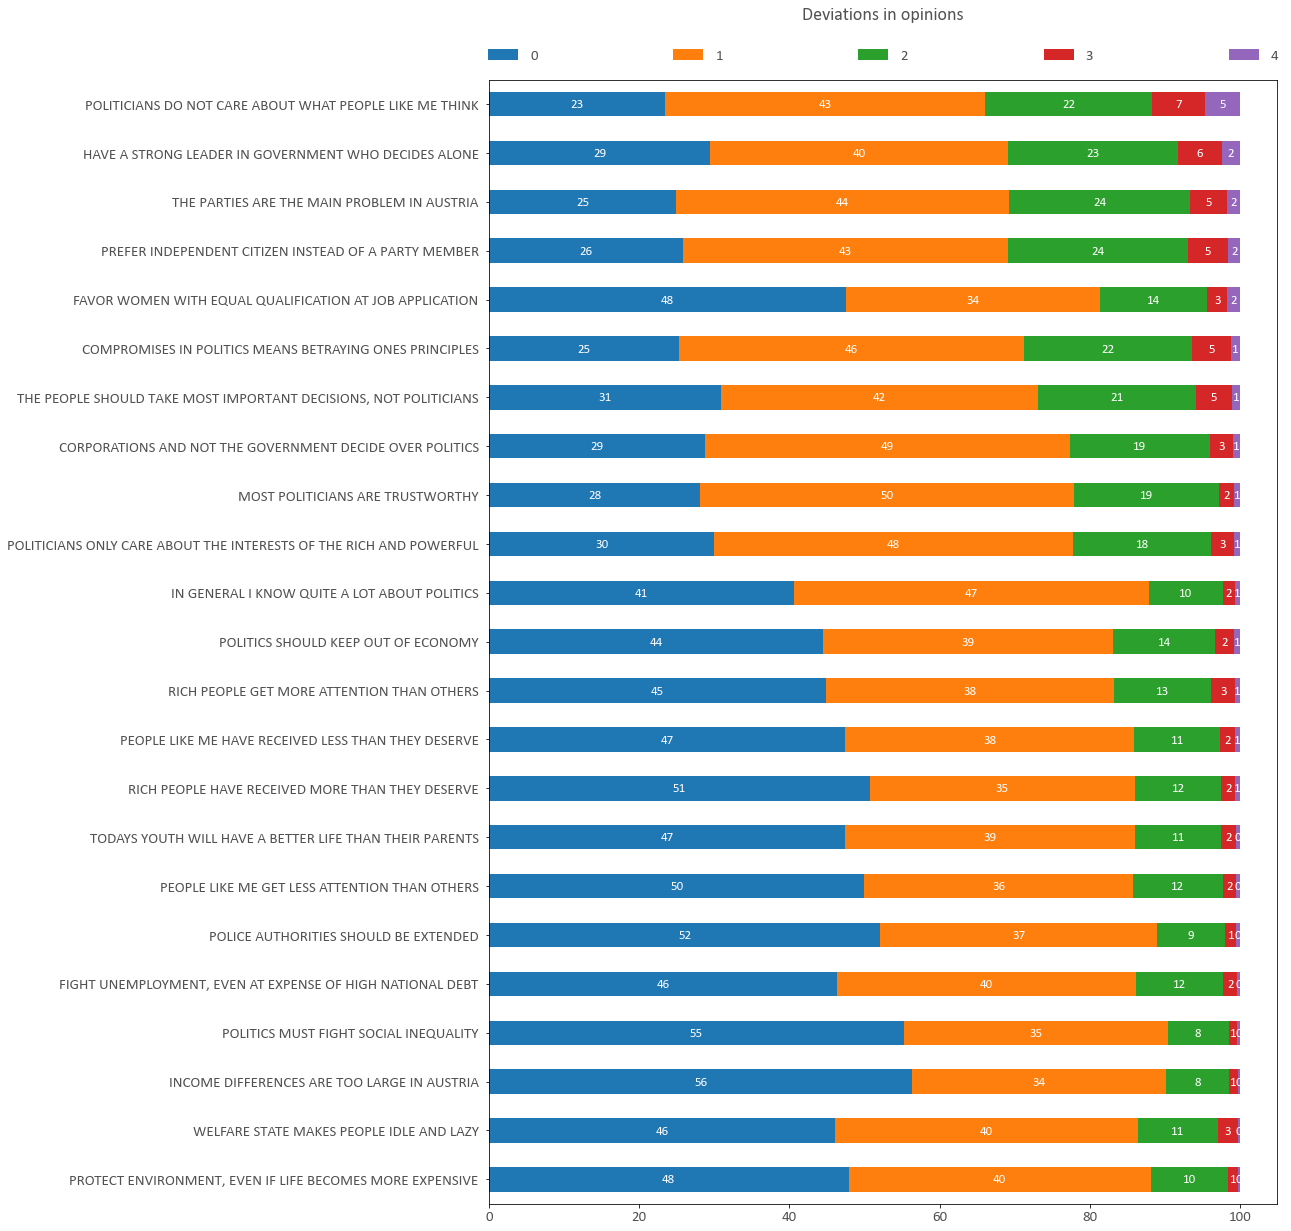

In [30]:
font_color = '#525252'
csfont = {'fontname': 'Calibri'}  # title font
hfont = {'fontname': 'Calibri'}  # main font

ax = opinion_deviations.T.plot.barh(
    align='center', stacked=True, figsize=(15, 20))  # , color='Pastel1'
plt.tight_layout()

title = plt.title('Deviations in opinions', pad=60,
                  fontsize=18, color=font_color, **csfont)

# Adjust the subplot so that the title would fit
plt.subplots_adjust(top=0.8, left=0.26)

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(15)
plt.xticks(color=font_color, **hfont)
plt.yticks(color=font_color, **hfont)

legend = plt.legend(loc='center',
                    frameon=False,
                    bbox_to_anchor=(0., .97, 1., .102),
                    mode='expand',
                    ncol=6,
                    borderaxespad=-.46,
                    prop={'size': 15, 'family': 'Calibri'})

for text in legend.get_texts():
    plt.setp(text, color=font_color)  # legend font color

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.text(x+width/2,
            y+height/2,
            '{:.0f}'.format(width),
            horizontalalignment='center',
            verticalalignment='center',
            color='white',
            fontsize=13,
            **hfont)

### Checking consistency of confidently clustered samples among the same questions in different waves

Next step is to check whether people, which are clustered with certain degree of close distance to centroids, were consistent with their responces among the same questions in different waves. Heatmap below shows std of selected individuals. This was pictured for 'closely located' twice: for those who participated in all waves

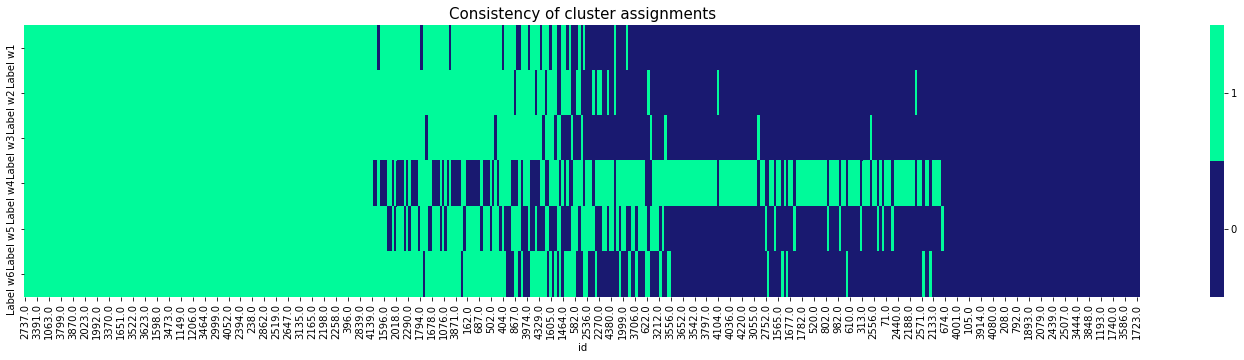

In [31]:
df_clustered_close = df_clustered

# filtering 'confidently' clusteres samples (if they participated in all waves and always were close to centroids)
for wave in waves:
    df_clustered_close = df_clustered_close.loc[
        df_clustered_close[f'Close to centroid w{wave}'] == 1]

f, ax = plt.subplots(figsize=(25, 5))
# Define colors
colors = ["midnightblue", "mediumspringgreen"]
cmap = LinearSegmentedColormap.from_list('Custom', colors, len(colors))
df_labels = df_clustered_close.filter(like='Label', axis=1)
df_labels['mean_label'] = df_labels.mean(axis=1)
df_labels.sort_values(by='mean_label', ascending=False, inplace=True)
df_labels.drop(columns=['mean_label'], inplace=True)
ax = sns.heatmap(df_labels.T, cmap=cmap)
# Set the colorbar labels
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0.25, 0.75])
colorbar.set_ticklabels(['0', '1'])
title = 'Consistency of cluster assignments'
plt.title(title, fontsize=15)
save_fig(title)

Cluster assignment is literally the same for them across the waves. Cluster 6 does not contain any immigration questions (causing the largest differences), therefore it is not possible to adequately compare it with others. However, if we delete immigration opinions to have the same base, that might change.

In [32]:
# convert this notebook to pdf but without the code
#!jupyter nbconvert --to pdf --TemplateExporter.exclude_input=True --output-dir=output_pdf clustering.ipynb